In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "STAT"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn140021,MVEAMVVVAPEVAVAMTWNSEGGSQREPTARETLERESVVIRKATV...,643,1
1,EMT21296,MAAPAEPGEIEGYLGLRDVRVKLDLGKARGRGEEGAGAGAGGGFAV...,690,1
2,AA31G00726,MASAISLNSSSGTLPLKSICKFKPIPRDPRFISCSRLSSSSLSREL...,2301,1
3,AA39G00006,MAGDSAIDTEKYTLLEDFNVDVEVENHEFKSFSLCFWVYLLDSTTY...,676,1
4,evm_27.model.AmTr_v1.0_scaffold00002.92,MPCEQALVEEDDEYVTLDKILINLQNPSSFTLCLWVYFLPPAPLSS...,719,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
115,0.002208,0.000000,0.002208,0.004415,0.000000,0.000000,0.000000,0.000000,0.004415,0.000000,...,0.000000,0.004415,0.0,0.0,0.002208,0.000000,0.002208,0.0,0.0,0.000000
306,0.026846,0.002237,0.002237,0.006711,0.004474,0.006711,0.004474,0.015660,0.008949,0.006711,...,0.000000,0.000000,0.0,0.0,0.002237,0.002237,0.006711,0.0,0.0,0.002237
316,0.000000,0.000000,0.000000,0.007843,0.000000,0.000000,0.000000,0.007843,0.003922,0.003922,...,0.003922,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
163,0.000000,0.000000,0.005102,0.005102,0.003401,0.000000,0.001701,0.001701,0.001701,0.003401,...,0.001701,0.001701,0.0,0.0,0.003401,0.000000,0.003401,0.0,0.0,0.000000
402,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (334, 432)
X_test: (84, 432)
y_train: (334,)
y_test: (84,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         110,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,113 (602.00 KB)

 Trainable params: 154,113 (602.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step - accuracy: 0.5000 - loss: 0.6934

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5399 - loss: 0.6929 - val_accuracy: 0.5970 - val_loss: 0.6888


Epoch 2/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7500 - loss: 0.6876

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7210 - loss: 0.6866 - val_accuracy: 0.8209 - val_loss: 0.6803


Epoch 3/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8906 - loss: 0.6794

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7909 - loss: 0.6774 - val_accuracy: 0.9403 - val_loss: 0.6658


Epoch 4/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.6642

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9615 - loss: 0.6595 - val_accuracy: 0.9403 - val_loss: 0.6378


Epoch 5/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.6299

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9505 - loss: 0.6243 - val_accuracy: 0.9851 - val_loss: 0.5984


Epoch 6/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.5986

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9926 - loss: 0.5813 - val_accuracy: 0.9851 - val_loss: 0.5245


Epoch 7/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.5149

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9800 - loss: 0.4983 - val_accuracy: 0.9851 - val_loss: 0.4342


Epoch 8/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.4146

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.3990 - val_accuracy: 0.9851 - val_loss: 0.3178


Epoch 9/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.3028

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9933 - loss: 0.2764 - val_accuracy: 1.0000 - val_loss: 0.2022


Epoch 10/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.2004

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9959 - loss: 0.1671 - val_accuracy: 0.9851 - val_loss: 0.1177


Epoch 11/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0927

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0860 - val_accuracy: 1.0000 - val_loss: 0.0601


Epoch 12/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0402

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9959 - loss: 0.0466 - val_accuracy: 0.9851 - val_loss: 0.0406


Epoch 13/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0276

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0234 - val_accuracy: 0.9851 - val_loss: 0.0304


Epoch 14/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0102

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 0.0177


Epoch 15/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0128

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0143


Epoch 16/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0047

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0119


Epoch 17/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0018

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0088


Epoch 18/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0030

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0067


Epoch 19/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0028

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9851 - val_loss: 0.0182



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


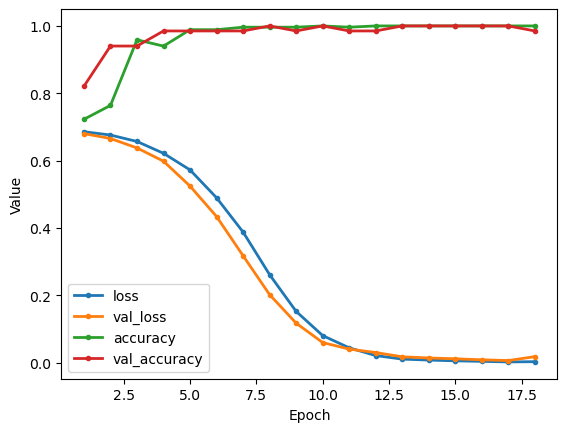

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYL,YYM,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYY
115,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
306,0.011211,0.0,0.0,0.0,0.0,0.004484,0.0,0.002242,0.002242,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002242,0.0,0.0
316,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
163,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
402,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.011236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (334, 7954)
X_test: (84, 7954)
y_train: (334,)
y_test: (84,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,036,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,079,745 (7.93 MB)

 Trainable params: 2,079,745 (7.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - accuracy: 0.4531 - loss: 0.6932

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4716 - loss: 0.6931 - val_accuracy: 0.5075 - val_loss: 0.6922


Epoch 2/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4062 - loss: 0.6938

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4749 - loss: 0.6922 - val_accuracy: 0.5075 - val_loss: 0.6898


Epoch 3/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4688 - loss: 0.6903

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4981 - loss: 0.6884 - val_accuracy: 0.5075 - val_loss: 0.6824


Epoch 4/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3906 - loss: 0.6873

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4885 - loss: 0.6805 - val_accuracy: 0.5075 - val_loss: 0.6701


Epoch 5/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4375 - loss: 0.6734

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4931 - loss: 0.6658 - val_accuracy: 0.5075 - val_loss: 0.6510


Epoch 6/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5156 - loss: 0.6469

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5052 - loss: 0.6421 - val_accuracy: 0.5075 - val_loss: 0.6116


Epoch 7/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5156 - loss: 0.6066

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5469 - loss: 0.5993 - val_accuracy: 0.6418 - val_loss: 0.5576


Epoch 8/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6875 - loss: 0.5584

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7563 - loss: 0.5371 - val_accuracy: 0.8507 - val_loss: 0.4741


Epoch 9/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9531 - loss: 0.4446

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9435 - loss: 0.4402 - val_accuracy: 0.9552 - val_loss: 0.3867


Epoch 10/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.3666

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9959 - loss: 0.3562 - val_accuracy: 0.9701 - val_loss: 0.3082


Epoch 11/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.2956

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.2821 - val_accuracy: 1.0000 - val_loss: 0.2263


Epoch 12/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.1965

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.1998 - val_accuracy: 1.0000 - val_loss: 0.1398


Epoch 13/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.1506

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.1224 - val_accuracy: 1.0000 - val_loss: 0.0645


Epoch 14/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0709

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0692 - val_accuracy: 1.0000 - val_loss: 0.0227


Epoch 15/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0478

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0366 - val_accuracy: 1.0000 - val_loss: 0.0100


Epoch 16/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0125

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0037


Epoch 17/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0102

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0019


Epoch 18/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0038

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0017


Epoch 19/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0076

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 6.8880e-04


Epoch 20/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0016

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 4.3789e-04


Epoch 21/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0097

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 0.0027



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


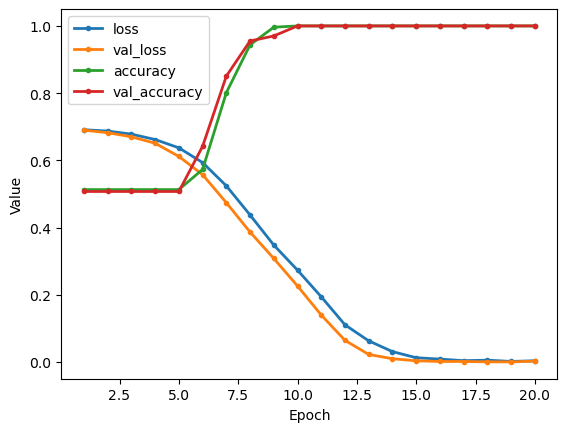

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYSN,YYST,YYTA,YYTS,YYTT,YYVK,YYVP,YYYR,YYYT,YYYY
115,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,0.006742,0.0,0.0,0.0,0.0,0.002247,0.0,0.0,0.0,0.0,...,0.0,0.0,0.002247,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      16,866,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,907,777 (64.50 MB)

 Trainable params: 16,907,777 (64.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step - accuracy: 0.5000 - loss: 0.6931

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5252 - loss: 0.6931 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5170 - loss: 0.6931

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5151 - loss: 0.6931 - val_accuracy: 0.5075 - val_loss: 0.6913


Epoch 2/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4219 - loss: 0.6925

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4896 - loss: 0.6911

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5217 - loss: 0.6904

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5296 - loss: 0.6903 - val_accuracy: 0.5075 - val_loss: 0.6846


Epoch 3/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7656 - loss: 0.6828

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8186 - loss: 0.6814

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8529 - loss: 0.6798

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8618 - loss: 0.6793 - val_accuracy: 0.8955 - val_loss: 0.6690


Epoch 4/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9844 - loss: 0.6645

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9887 - loss: 0.6613

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9902 - loss: 0.6587

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9906 - loss: 0.6579 - val_accuracy: 1.0000 - val_loss: 0.6385


Epoch 5/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.6272

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.6195

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9985 - loss: 0.6148

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9981 - loss: 0.6136 - val_accuracy: 1.0000 - val_loss: 0.5893


Epoch 6/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.5653

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.5556

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.5465

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.5439 - val_accuracy: 1.0000 - val_loss: 0.5148


Epoch 7/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.4749

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.4600

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.4456

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.4418 - val_accuracy: 1.0000 - val_loss: 0.4187


Epoch 8/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.3325

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.3235

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.3138

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.3112 - val_accuracy: 1.0000 - val_loss: 0.2995


Epoch 9/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.2035

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.1973

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.1896

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.1875 - val_accuracy: 1.0000 - val_loss: 0.1869


Epoch 10/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.1116

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.1025

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0965

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0950 - val_accuracy: 1.0000 - val_loss: 0.1156


Epoch 11/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0442

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0433

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0415

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0410 - val_accuracy: 1.0000 - val_loss: 0.0769


Epoch 12/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0197

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0180

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0171

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0403


Epoch 13/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0079

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0078

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0076

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0213


Epoch 14/100


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0044

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0041

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0040

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0154



[Train Accuracy: 100.00% - Test Accuracy: 98.81%]


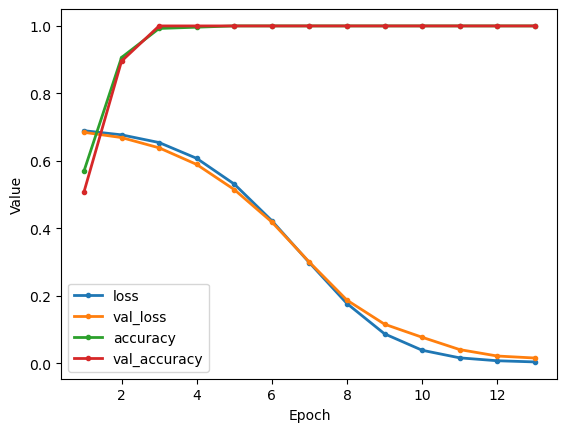

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [25]:
report.save()

Report saved as Output/Reports/STAT/report_253SZUK8.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################